# Data Fusion Bonus Part III

Hi everyone, as I work on the PointNet section, I wanted to create a bonus section here. In the previous part we were able to use PointPainting to decorate a lidar point of the format NxL where N is the number of points and L is the lidar features. Using PointPainting we were able to convert this to an Nx(L + C) but we can do much more with this. In this bonus section we will simply add color to our lidar point decoration. Hence we will now have a lidar with Nx(L + C + R + G + B). Some lidars may already have this feature but what if we poses a lidar that does not but we still want to create extra features for our ML model to learn. Hence, we will use the same principles of pointpainting, however this time we will decorate our lidar with color features. 

In [99]:
%load_ext autoreload
%autoreload 2
from point_painter import PointPainter
from data_fusion_utils import *
import glob
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Matrix R0 (3, 3):
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix P (3, 4):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
Matrix R (3, 3):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
Vector t (3, 1):
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]
Matrix R|t (3, 4):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]
Matrix R0 (3, 3):
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix P (3, 4):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e

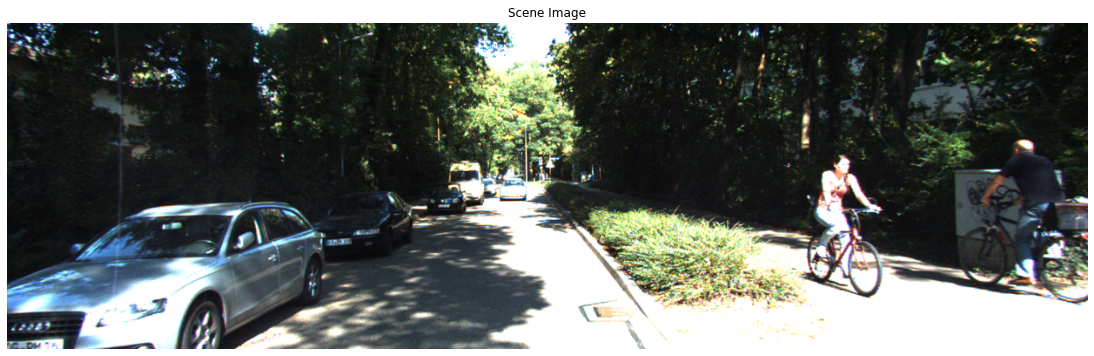

In [100]:
#Lets load lidar data
lidar_data_path = "../DATA/lidar_data/*.pcd"
lidar_file_names = sorted(glob.glob(lidar_data_path))
#Lets load image data
image_data_path = "../DATA/image_02/data/*.png"
image_file_names = sorted(glob.glob(image_data_path))

#Lets choose the first image and lidar point cloud 
index = 0
image_file = image_file_names[index]
lidar_file = lidar_file_names[index]

# Next lets load the points and image
point_cloud = o3d.io.read_point_cloud(lidar_file)
X = np.asarray(point_cloud.points)

img = cv2.cvtColor(cv2.imread(image_file),  cv2.COLOR_BGR2RGB)


# Based on the class we need to subset the points within the image


# Load projection matrices 
P, R_0, R_t = load_calibrations()

# Lets Set frustum indices (fov)
xmin, ymin, xmax, ymax = (0, 0, img.shape[1], img.shape[0])

# Load projection matrices 
P, R_0, R_t = load_calibrations()

#Select points within frontal 180 degrees by getting rid of those points in -x direction in keeping the +x 
indices_180 = np.where(X[:, 0] >=  0)[0]
X_180 = X[indices_180]

# Frist Project points 
Y = project_points(P, R_0, R_t, X_180)
# Get the indices within frustum
indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]

X_frustum = X_180[indices_frustum]


# Now we get the pixel mapping of X_frustum, make sure to convert to int 
Y_frustum = project_points(P, R_0, R_t, X_frustum).astype(np.uint16)


#Plot image
plt.figure(figsize=(20, 6))
plt.imshow(img)
plt.title("Scene Image")
plt.axis("off")
plt.show()


# Adding Color label to each point cloud

We will follow the exact algorithm used to decorate the lidar with a class label. 

1. Create an empty `color_labels` int numpy matrix of the same size as the number of points in our lidar point cloud.
2. We iterate starting from the top left corner of the image we start at the height which is `y` then we iterate over the width or `x`. Hence, we will be at each pixel coordinate location (y,x) of the image. Here we will use the actual image instead of the per_pixel_score
3. At each pixel coordinate location (y, x) we get the indices of all the lidar pixel coordinates from `Y_frustum_int` that are equal to the current (y, x) pixel coordinate.
4. We then use those `indices` to set all values in `color_labels` the the 3 color channel `image` at the current pxiel coordinate.  

In [101]:
#Let us now assign a per point semantic label to the lidar point cloud
color_labels = np.zeros((Y_frustum.shape[0], 3))
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        #Get indices where any pixels in Y_frustum_int are the current y,x pixel
        indices = np.where((Y_frustum[:, 0] == x) & (Y_frustum[:, 1] == y))[0]
        #Set labels at incdices with their class label defined by per_pixel score
        color_labels[indices, :]  = np.array(img[y, x])

In [102]:
color_labels

array([[ 73.,  97.,  26.],
       [ 81.,  88.,  91.],
       [ 38.,  49.,  29.],
       ...,
       [255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.]])

In [103]:
# Create an Open3D PointCloud object
pcd = o3d.geometry.PointCloud()
# Assign the XYZ coordinates to the point cloud
pcd.points = o3d.utility.Vector3dVector(X_frustum)
# Assign the RGB colors to the point cloud make sure to normalize them by 255
pcd.colors = o3d.utility.Vector3dVector(color_labels/255)

In [104]:
visualize_cloud([pcd])

### Output

![OUTPUT](../Doc_Images/DATAFUSION_DOC_IMAGES/part_III_color_labels.png)

## Getting overal features

Now we will get all of the features xyz, rgb, and class all in one matrix.

In [105]:
#Instantiate point painter class
cloud_painter = PointPainter(P, R_0, R_t)
point_painting_detections = cloud_painter.paintCloud(img, X_frustum)

C:\Users\adela\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [106]:
# Lets again observe the output from the pointpainting class
point_painting_detections.keys()

dict_keys(['pred_mask', 'pred_labels', 'pred_scores', 'semantic_image', 'per_pixel_score', 'lidar_labels', 'lidar_color_map', 'lidar_image'])

In [112]:
# Lets get the class labels
class_labels = point_painting_detections['lidar_labels']

# Lets verify these are of the same length
print(len(color_labels) == len(X_frustum) == len(class_labels))

True


In [113]:
# Lets get our entire matrix
lidar_xyzrgbc = np.hstack((X_frustum, color_labels, class_labels.reshape(-1, 1)))

In [115]:
lidar_xyzrgbc[0]

array([57.38899994,  7.92000008,  2.16799998, 73.        , 97.        ,
       26.        ,  0.        ])

In [121]:
lidar_xyzrgbc[792]

array([ 37.47499847,   3.77099991,   1.06599998, 140.        ,
       191.        , 251.        ,   8.        ])

# Conclusion

In this bonous section we were able to add a color feature label to each point in our point cloud by using sensor fusion concepts. 
Were able to convert this to an NxL to a  Nx(L + C + R + G + B) by using data fusion applying the correct projection maping between 3D lidar points in space and pixels in the image plane using the color at each pixel to decorate our lidar data with an RGB value. 